# Analisis Exploratorio

In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings

warnings.filterwarnings('ignore')

### Lectura de datos
Leemos los datos de los csv para y creamos el dataframe y el diccionario de datos

In [119]:
data = pd.read_csv('../Datasets/application_train.csv')
data.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [120]:
data.shape

(307511, 122)

In [121]:
dict_descriptions = {}
df_descriptions = pd.read_csv('../Datasets/HomeCredit_columns_description.csv',encoding='ISO-8859-1')
np_descriptions = df_descriptions[df_descriptions['Table']=='application_{train|test}.csv'][['Row','Description']].values
for key,value in np_descriptions:
    dict_descriptions[key] = value
len(dict_descriptions),dict_descriptions

(122,
 {'SK_ID_CURR': 'ID of loan in our sample',
  'TARGET': 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
  'NAME_CONTRACT_TYPE': 'Identification if loan is cash or revolving',
  'CODE_GENDER': 'Gender of the client',
  'FLAG_OWN_CAR': 'Flag if the client owns a car',
  'FLAG_OWN_REALTY': 'Flag if client owns a house or flat',
  'CNT_CHILDREN': 'Number of children the client has',
  'AMT_INCOME_TOTAL': 'Income of the client',
  'AMT_CREDIT': 'Credit amount of the loan',
  'AMT_ANNUITY': 'Loan annuity',
  'AMT_GOODS_PRICE': 'For consumer loans it is the price of the goods for which the loan is given',
  'NAME_TYPE_SUITE': 'Who was accompanying client when he was applying for the loan',
  'NAME_INCOME_TYPE': 'Clients income type (businessman, working, maternity leave,\x85)',
  'NAME_EDUCATION_TYPE': 'Level of highest education the client achie

### Informacion de las variables

Las variables se pueden dividir segun el tipo de informacion que proporcionan del cliente

In [122]:
inf_personal = ['CODE_GENDER','CNT_CHILDREN','NAME_FAMILY_STATUS','CNT_FAM_MEMBERS','DAYS_BIRTH']
inf_laboral = ['AMT_INCOME_TOTAL','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED','ORGANIZATION_TYPE']
inf_posesiones = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_HOUSING_TYPE','OWN_CAR_AGE']
inf_prestamo = ['NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
inf_comunicacion = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
inf_direccion = ['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
                'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']
inf_scores = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
inf_documents = [var for var in data if 'FLAG_DOCUMENT' in var]
inf_bureauCalls = [var for var in data if 'AMT_REQ_CREDIT_BUREAU' in var]
inf_agregation = [var for var in data if '_AVG' in var or '_MEDI' in var or '_MODE' in var]

Tambien segun el tipo de variable que sean numericas o categoricas(cat. ordinales o cat. nominales)

In [123]:
variables_obj = [var for var in data if data[var].nunique()<60 or data[var].dtype=='O']
variables_num = list ( set(data.columns) - set(variables_obj) )
print(f"Numero de variables categoricas: {len(variables_obj)}")
print(f"Numero de variables numericas: {len(variables_num)}")

Numero de variables categoricas: 72
Numero de variables numericas: 50


Podemos notar que tenemos un desbalanceo entre las clases de la variable target.

In [124]:
val_target = data['TARGET'].value_counts()
val_target = val_target/sum(val_target)
np.round(val_target*100,2)

TARGET
0    91.93
1     8.07
Name: count, dtype: float64

### Graficas univariadas y bivariadas (variable vs target)

Consideraciones:
- Se considera que el target es una variable binaria
- Se considera una variable discreta numerica como una categorica (categorica ordinal)
  
Tenemos 3 funciones:

- EDA_graf_categoricas: Nos da 2 graficas, la primera es una simple grafica de frecuencias de las clases de la variable categorica, la segunda es una grafica de los procentajes de la variable target filtrando sobre cada una de esas clases en donde la linea roja representa el porcentaje global del target.

- EDA_graf_numericas : Nos da 2 graficas, la primera es la distribucion de la variable numerica, la segunda son 2 distribuciones para cada valor de la variable target

- graficar_EDA : Apartir de una lista de variables, se escoge cualquiera de las 2 funciones anteriores para graficarlas.
  

In [125]:
# Grafica para variables categorica y target binario
def EDA_graf_categoricas(df_,target,variable):
    
    df = df_.copy()
    df[variable] = df_[variable].astype('str')
    df = df.fillna('Nulo')
    clases = df[variable].unique()
    
    clases_per1 = []

    f,ax = plt.subplots(1,2)
    f.set_size_inches(9,4)
    sns.set_style('whitegrid')
    
    for clase in clases:
        application_clase = df.loc[df[variable]==clase]
        application_clase_1 = application_clase.query(f'{target}==1')
        clases_per1.append(application_clase_1.shape[0]/application_clase.shape[0])

    ax_1 = sns.countplot(data=df,x=variable,ax=ax[0])
    ax_2 = sns.barplot(x=clases,y=clases_per1,ax=ax[1])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

    ax_2.axhline(y=0.081, color='red', linestyle='--',label='% de 1s')
    plt.xlabel(f'{variable}')
    plt.ylabel('% de 1s x clase')
    plt.show()

# Grafica para variables numericas y target binario
def EDA_graf_numericas(df_,target,variable):
    
    df = df_.dropna(subset=variable)
    df.reset_index(inplace=True)
    p_99 =df[variable].quantile(0.999)
    df = df.query(f'{variable}<{p_99}')
    
    df_0 = df.query(f'{target}==0')[variable]
    df_1 = df.query(f'{target}==1')[variable]
    
    f,ax = plt.subplots(1,2)
    f.set_size_inches(9,4)
    sns.set_style('whitegrid')

    sns.distplot(df[variable],hist=False,color='black',kde=True,ax=ax[0])
    sns.distplot(df_0,hist=False,color='green',kde=True,ax=ax[1],label='cumplen')
    sns.distplot(df_1,hist=False,color='red',kde=True,ax=ax[1],label='incumplen')
    
    f.suptitle(f'Distribucion 99.5%',fontsize=18)
    plt.legend()
    plt.show()

# Graficas para un target binario
def graficar_EDA(df,target,variables):
    for variable in variables:
        if df[variable].nunique()<=10 or df[variable].dtype=='O':
            EDA_graf_categoricas(df,target,variable)
        else:
            EDA_graf_numericas(df,target,variable)
            

### Descripcion de las variables categoricas
Descripcion de las variables categoricas, la cantidad y el porcentaje de las clases que existen en cada una (contando a los nulos)

In [207]:
# Descripcion de variables categoricas
def describe_categoricas(df_,variables,hide=False):

    df = df_.copy()
    df.fillna('nulo',inplace=True)
    cantidades = []
    porcentajes = []
    index1 = []
    index2 = []
    
    for var in variables:
        i_1 =  [var]*df[var].nunique()
        i_2 = list(df[var].unique())

        # Conteo de las clases de la variable
        valores = df[var].value_counts()
        valores_conteo = list(valores.values)

        # Porcentajes de las clases de la variable
        valores_per = valores/sum(valores)
        valores_porcentaje = list(valores_per.values)

        # Si hide!=False y el numero de variables es mayor que el indicado -> entra
        if df[var].nunique()>hide and hide:
            # Cambiamos los indices
            i_1 = i_1[:hide+1]
            i_2 = i_2[:hide] + ['otros']
            
            # Sumamos los conteos
            otros_conteo = sum(valores_conteo[hide+1:]) 
            otros_porcentaje = sum(valores_porcentaje[hide+1:])

            # Guardamos en valores_conteo y modificamos el ultimo con la suma de los que quedaron
            valores_conteo = valores_conteo[:hide] + [otros_conteo]
            valores_porcentaje = valores_porcentaje[:hide] + [otros_porcentaje]

        # Concatenamos a las listas 
        index1 += i_1
        index2 += i_2
        cantidades += valores_conteo
        porcentajes += valores_porcentaje

    # Le damos formato
    cantidades = np.array(cantidades).astype('int')
    porcentajes = [x+'%' for  x in np.round(np.array(porcentajes)*100,3).astype('str')]

    # definimos la tabla para crear el dataframe
    tabla = {'porcentaje': porcentajes,
             'cantidad': cantidades,
             'clases': index2}
    tabla = pd.DataFrame(tabla,index=index1)

    # Editamos para tener 2 indices
    tabla = tabla.set_index('clases',append=True)
    
    return tabla    

### Informacion personal

- CODE_GENDER : Genero de la persona (M,F).
- CNT_CHILDREN : Numero de hijos.
- NAME_FAMILY_STATUS : Estado civil de la persona.
- CNT_FAM_MEMBERS : Numero de miembros de la familia.
- DAYS_BIRTH : Fecha de nacimiento (dias atras).

In [197]:
var_cat = ['CODE_GENDER','NAME_FAMILY_STATUS']
var_num = ['DAYS_BIRTH','CNT_CHILDREN','CNT_FAM_MEMBERS']

In [198]:
data[var_num].describe()

DAYS_BIRTH   CNT_CHILDREN  CNT_FAM_MEMBERS
count  307511.000000  307511.000000    307509.000000
mean   -16036.995067       0.417052         2.152665
std      4363.988632       0.722121         0.910682
min    -25229.000000       0.000000         1.000000
25%    -19682.000000       0.000000         2.000000
50%    -15750.000000       0.000000         2.000000
75%    -12413.000000       1.000000         3.000000
max     -7489.000000      19.000000        20.000000

In [211]:
describe_categoricas(data,var_cat,12)

porcentaje  cantidad
                    clases                                            
NAME_INCOME_TYPE    Working                          51.632%    158774
                    State servant                    23.289%     71617
                    Commercial associate             18.003%     55362
                    Pensioner                         7.058%     21703
                    Unemployed                        0.007%        22
                    Student                           0.006%        18
                    Businessman                       0.003%        10
                    Maternity leave                   0.002%         5
NAME_EDUCATION_TYPE Secondary / secondary special    71.019%    218391
                    Higher education                 24.345%     74863
                    Incomplete higher                 3.342%     10277
                    Lower secondary                   1.241%      3816
                    Academic degree                   0.053%       164
OCCUPATION_TYPE     Laborers                         31.346%     96391
                    Core staff                       17.946%     55186
                    Accountants                      10.439%     32102
                    Managers                          8.966%     27570
                    nulo                               6.95%     21371
                    Drivers                            6.05%     18603
                    Sales staff                       3.701%     11380
                    Cleaning staff                    3.191%      9813
                    Cooking staff                     2.776%      8537
                    Private service staff             2.186%      6721
                    Medicine staff                    1.934%      5946
                    Security staff                    1.513%      4653
                    otros                             2.142%      6586
ORGANIZATION_TYPE   Business Entity Type 3            22.11%     67992
                    School                           18.007%     55374
                    Government                       12.491%     38412
                    Religion                          5.425%     16683
                    Other                              3.64%     11193
                    XNA                               3.432%     10553
                    Electricity                       3.383%     10404
                    Medicine                          2.892%      8893
                    Business Entity Type 2            2.547%      7831
                    Self-employed                     2.237%      6880
                    Transport: type 2                 2.186%      6721
                    Construction                      1.946%      5984
                    otros                            17.948%     55193

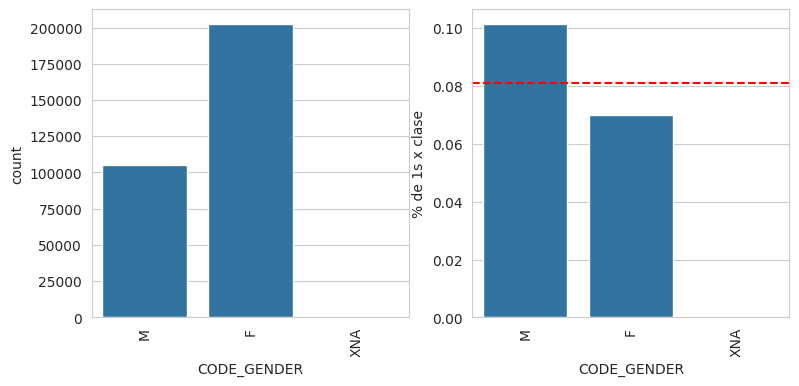

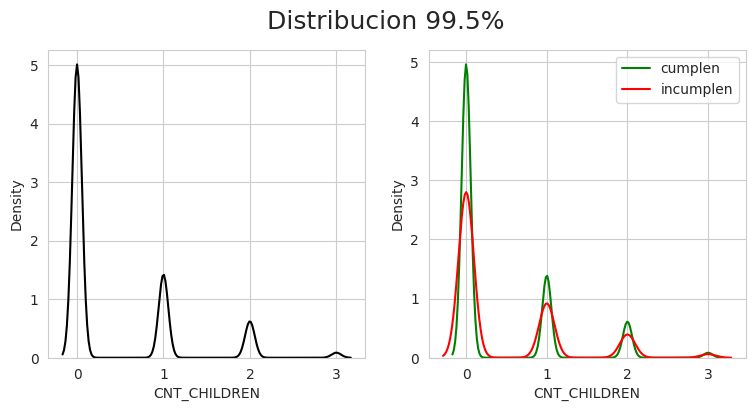

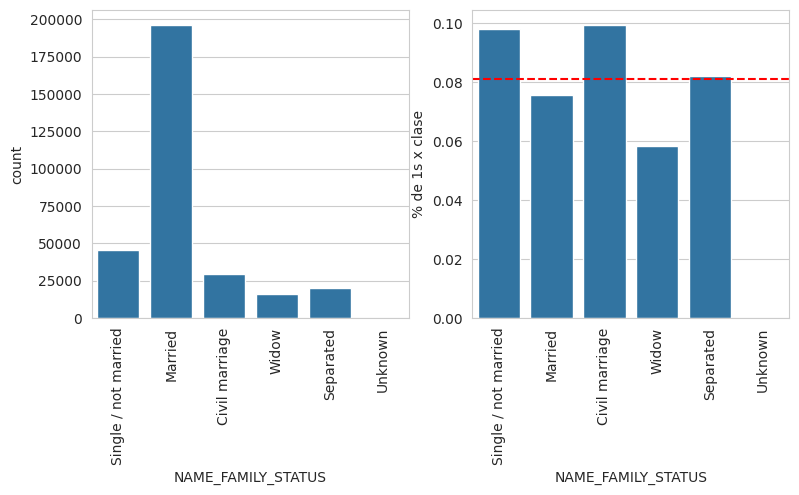

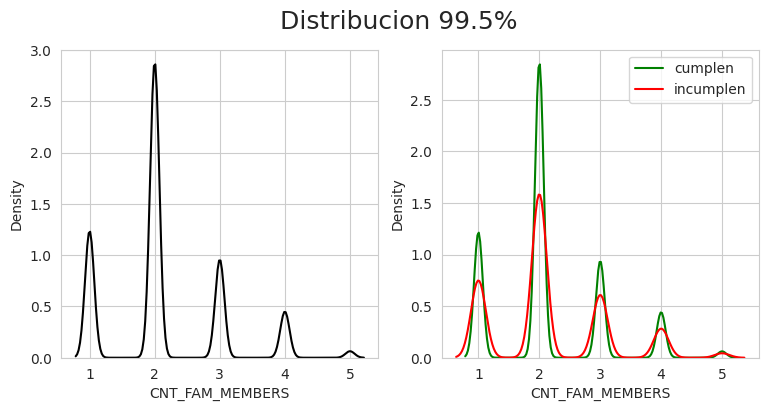

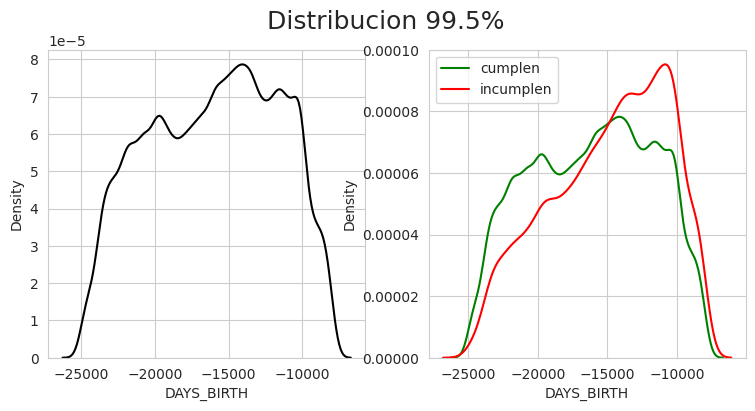

In [27]:
graficar_EDA(data,'TARGET',inf_personal)

### Informacion Laboral
- AMT_INCOME_TOTAL : Ingreso total de la persona.
- NAME_INCOME_TYPE : Tipo del ingreso de la persona.
- NAME_EDUCATION_TYPE : Tipo de educacion de la persona.
- OCCUPATION_TYPE : Tipo de ocupacion
- DAYS_EMPLOYED : Dias de desempleado que tiene la persona
- ORGANIZATION_TYPE : El tipo de la organizacion para la cual trabaja.

In [212]:
var_cat = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']
var_num = ['AMT_INCOME_TOTAL','DAYS_EMPLOYED']

In [213]:
data[var_num].describe()

AMT_INCOME_TOTAL  DAYS_EMPLOYED
count      3.075110e+05  307511.000000
mean       1.687979e+05   63815.045904
std        2.371231e+05  141275.766519
min        2.565000e+04  -17912.000000
25%        1.125000e+05   -2760.000000
50%        1.471500e+05   -1213.000000
75%        2.025000e+05    -289.000000
max        1.170000e+08  365243.000000

In [214]:
describe_categoricas(data,var_cat,12)

porcentaje  cantidad
                    clases                                            
NAME_INCOME_TYPE    Working                          51.632%    158774
                    State servant                    23.289%     71617
                    Commercial associate             18.003%     55362
                    Pensioner                         7.058%     21703
                    Unemployed                        0.007%        22
                    Student                           0.006%        18
                    Businessman                       0.003%        10
                    Maternity leave                   0.002%         5
NAME_EDUCATION_TYPE Secondary / secondary special    71.019%    218391
                    Higher education                 24.345%     74863
                    Incomplete higher                 3.342%     10277
                    Lower secondary                   1.241%      3816
                    Academic degree                   0.053%       164
OCCUPATION_TYPE     Laborers                         31.346%     96391
                    Core staff                       17.946%     55186
                    Accountants                      10.439%     32102
                    Managers                          8.966%     27570
                    nulo                               6.95%     21371
                    Drivers                            6.05%     18603
                    Sales staff                       3.701%     11380
                    Cleaning staff                    3.191%      9813
                    Cooking staff                     2.776%      8537
                    Private service staff             2.186%      6721
                    Medicine staff                    1.934%      5946
                    Security staff                    1.513%      4653
                    otros                             2.142%      6586
ORGANIZATION_TYPE   Business Entity Type 3            22.11%     67992
                    School                           18.007%     55374
                    Government                       12.491%     38412
                    Religion                          5.425%     16683
                    Other                              3.64%     11193
                    XNA                               3.432%     10553
                    Electricity                       3.383%     10404
                    Medicine                          2.892%      8893
                    Business Entity Type 2            2.547%      7831
                    Self-employed                     2.237%      6880
                    Transport: type 2                 2.186%      6721
                    Construction                      1.946%      5984
                    otros                            17.948%     55193

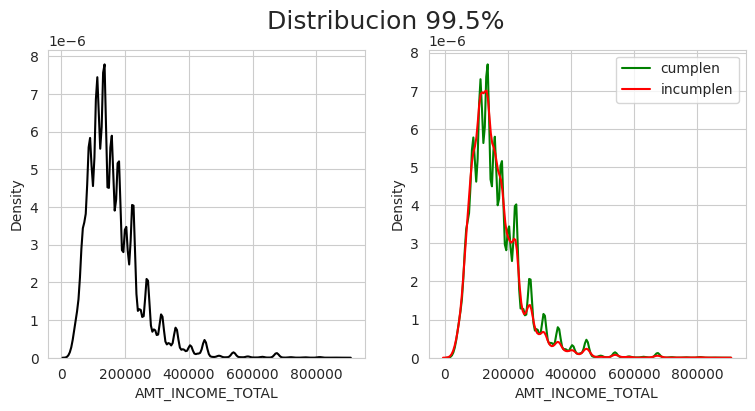

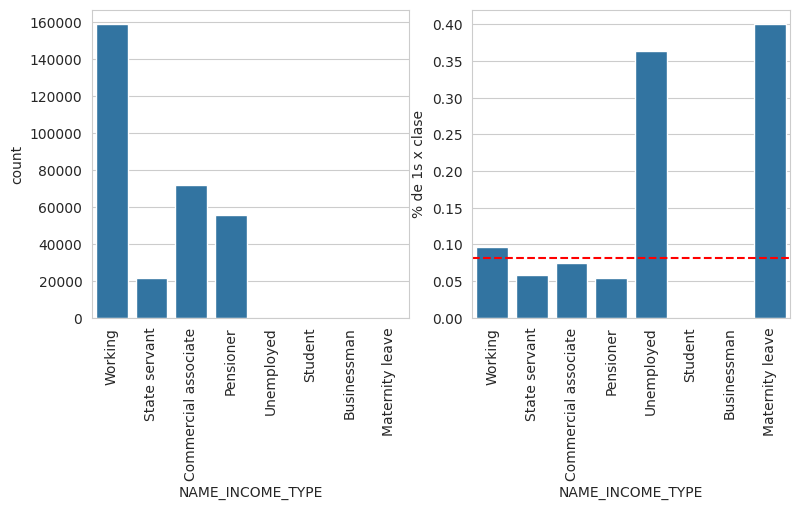

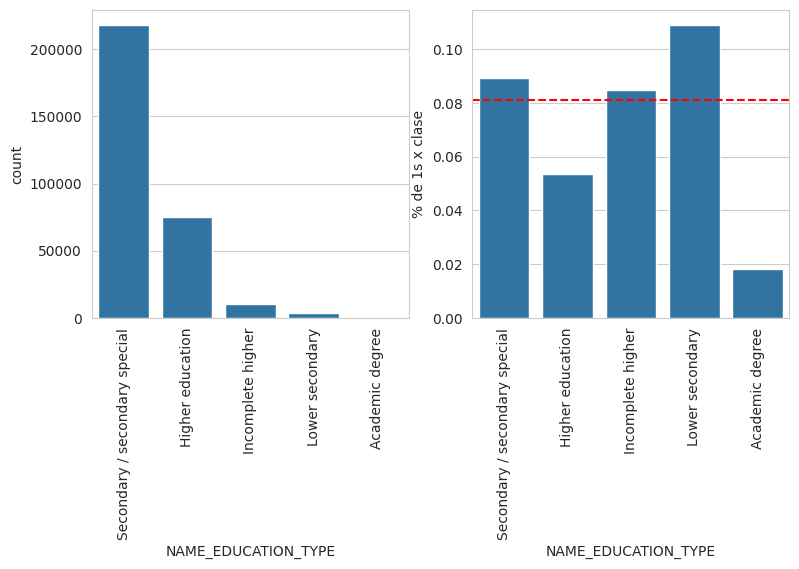

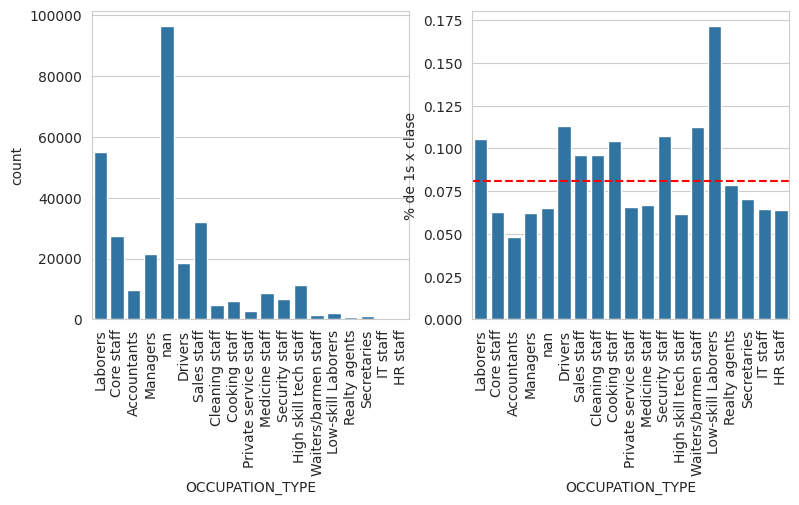

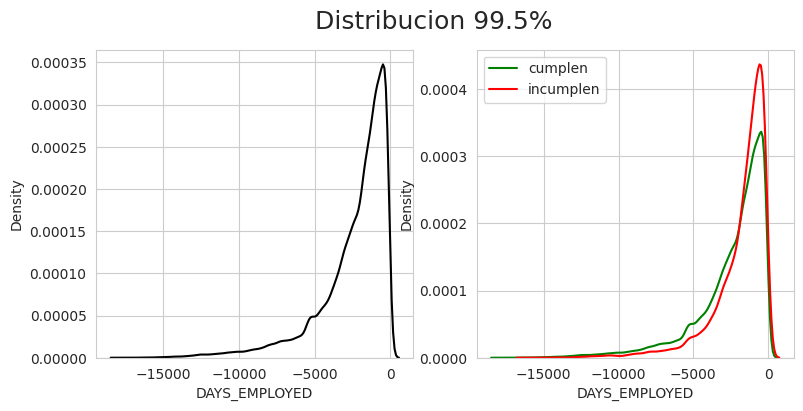

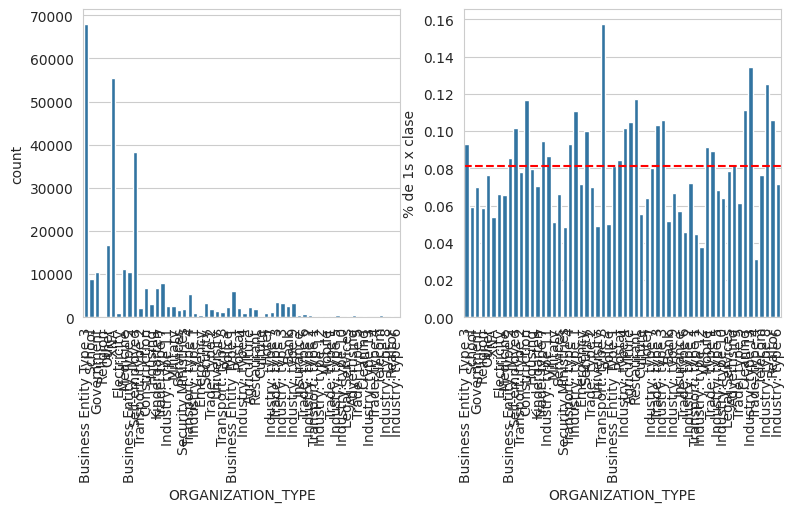

In [29]:
graficar_EDA(data,'TARGET',inf_laboral)

### Informacion Posesion
- FLAG_OWN_CAR : Si la persona tiene o no carro propio
- FLAG_OWN_REALTY : Si la persona tiene una casa o piso propio
- NAME_HOUSING_TYPE : Situacion de vivienda del cliente
- OWN_CAR_AGE : Anios que tiene el carro propio

In [215]:
var_cat = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_HOUSING_TYPE']
var_num = ['OWN_CAR_AGE']

In [217]:
data[var_num].describe()

OWN_CAR_AGE
count  104582.000000
mean       12.061091
std        11.944812
min         0.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        91.000000

In [218]:
describe_categoricas(data,var_cat,12)

porcentaje  cantidad
                  clases                                  
FLAG_OWN_CAR      N                      65.989%    202924
                  Y                      34.011%    104587
FLAG_OWN_REALTY   Y                      69.367%    213312
                  N                      30.633%     94199
NAME_HOUSING_TYPE House / apartment      88.734%    272868
                  Rented apartment        4.826%     14840
                  With parents            3.637%     11183
                  Municipal apartment     1.587%      4881
                  Office apartment        0.851%      2617
                  Co-op apartment         0.365%      1122

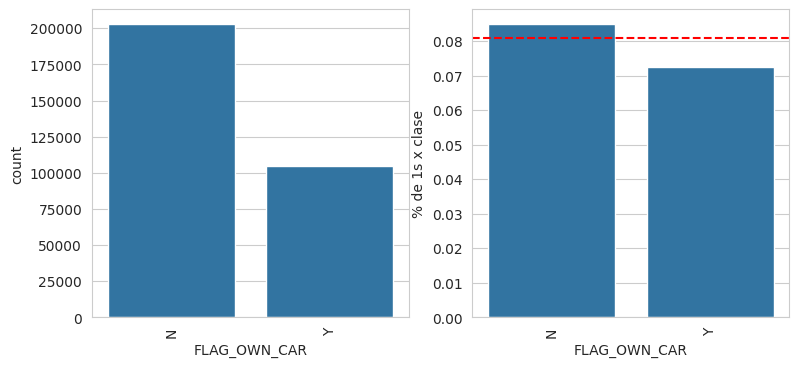

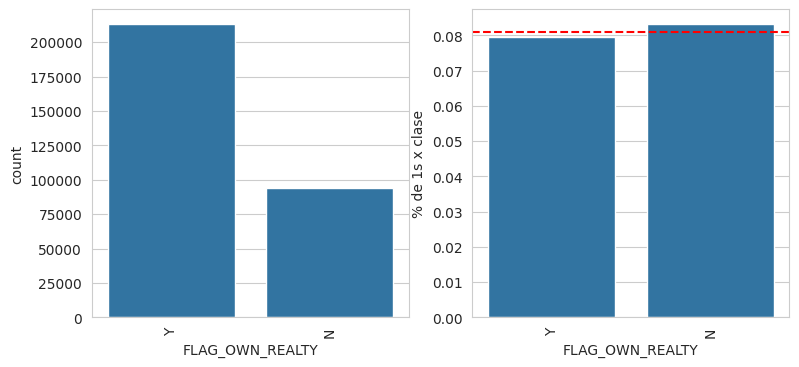

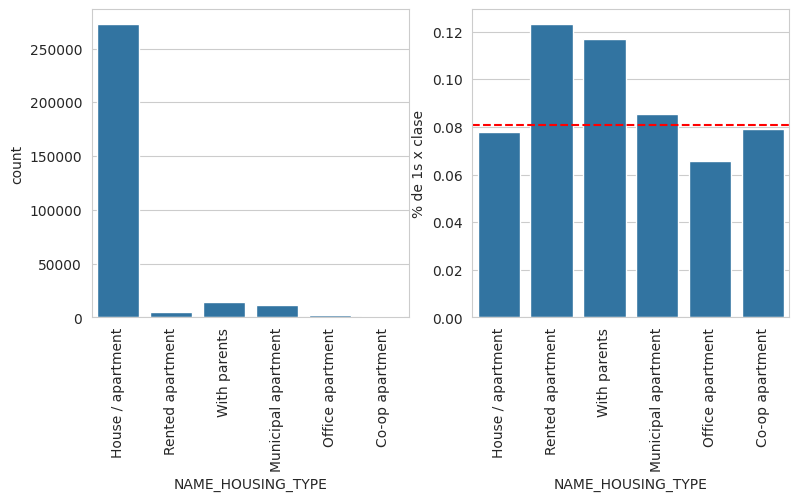

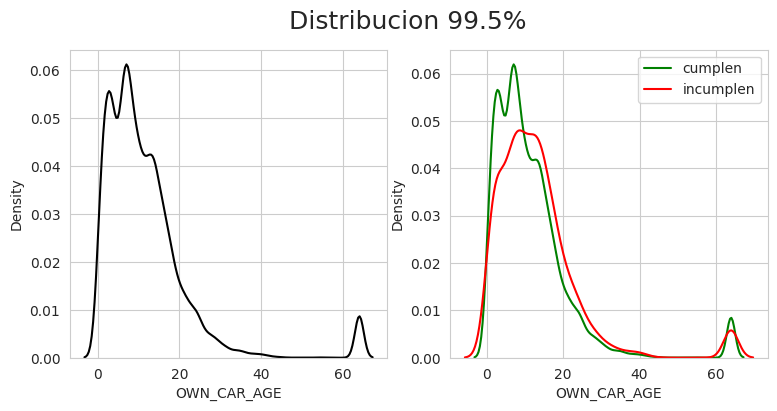

In [30]:
graficar_EDA(data,'TARGET',inf_posesiones)

### Informacion del prestamo
- NAME_CONTRACT_TYPE : Tipo de prestamo.
- AMT_CREDIT : Monto que se le prestara a la persona.
- AMT_ANNUITY : Monto anual a pagar por anio
- AMT_GOODS_PRICE : Monto de los bienes por cual fue otorgado el prestamo.
- NAME_TYPE_SUITE : Con quien fue la persona a pedir el prestamo
- DAYS_REGISTRATION : Cuantos dias antes de la aplicacion al prestamo el cliente cambio su registro.
- DAYS_ID_PUBLISH : Cuantos dias antes de la aplicacion al prestamo el cliente cambio su documento de identidad.

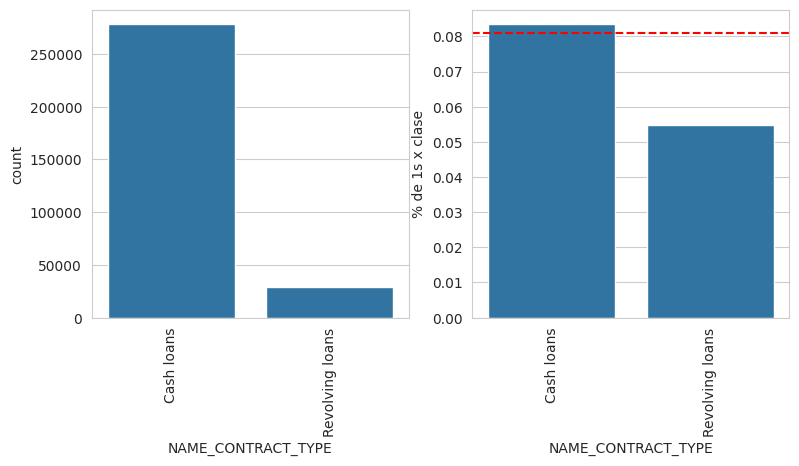

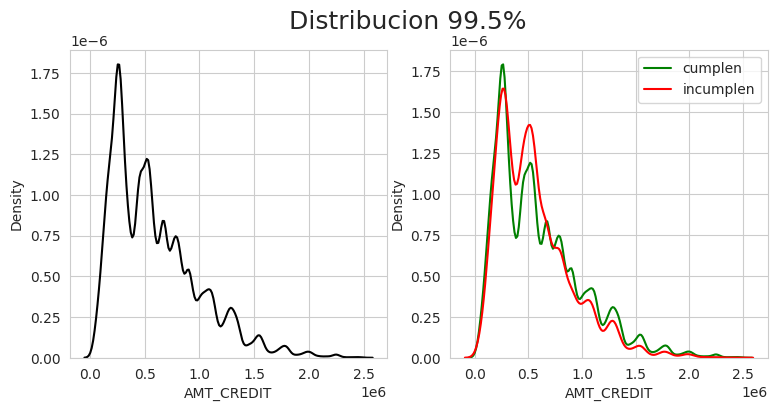

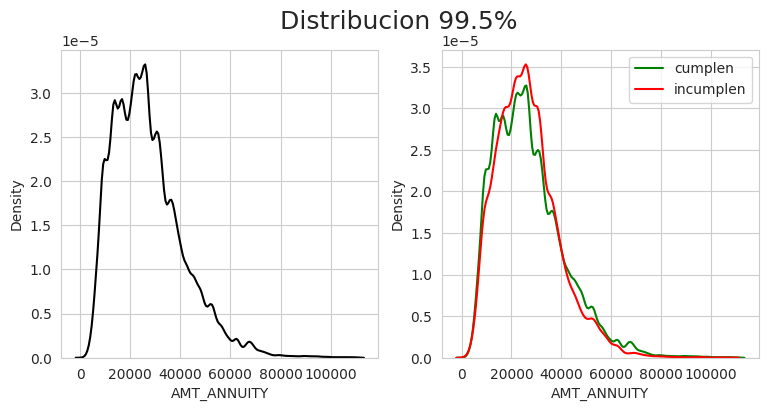

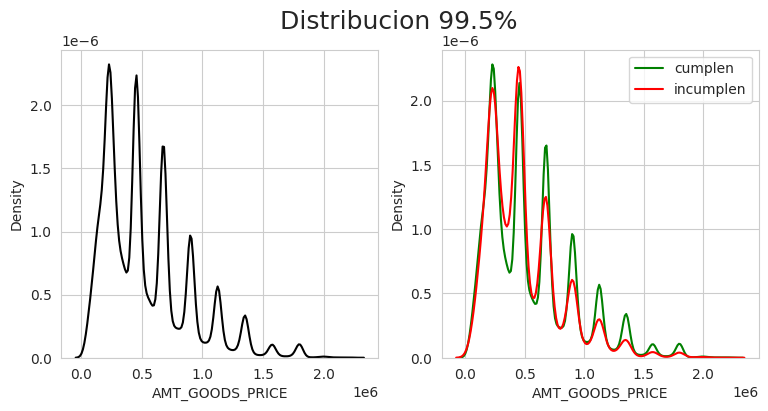

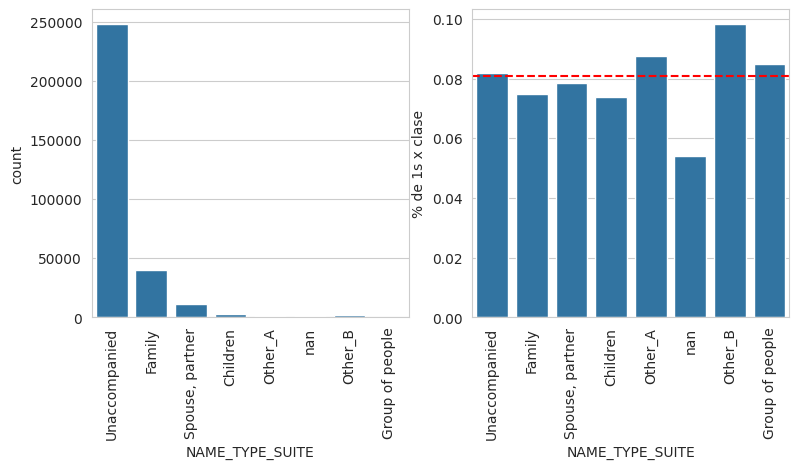

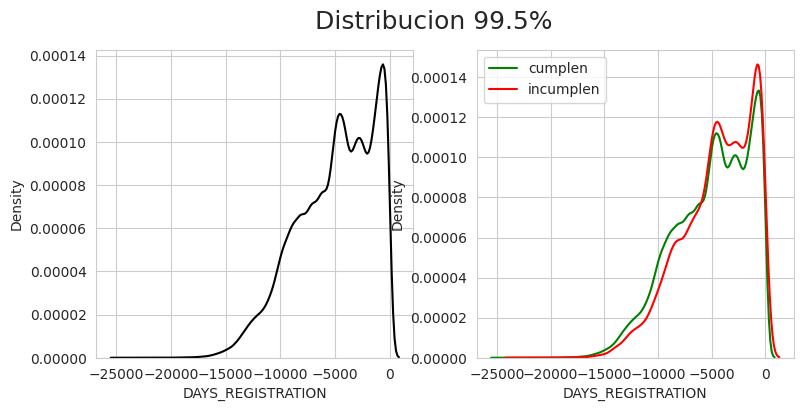

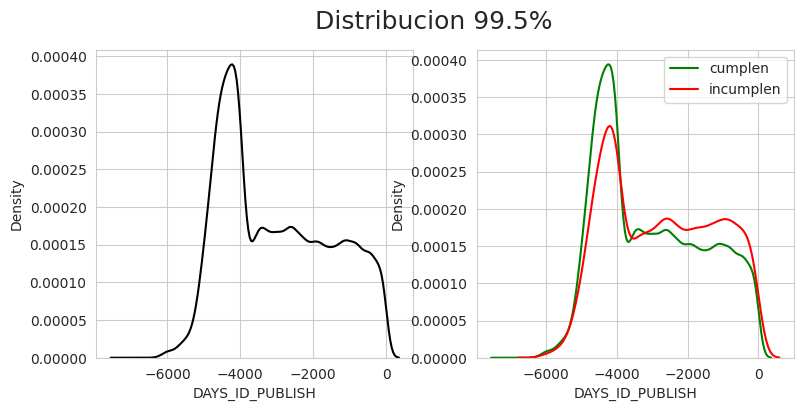

In [31]:
graficar_EDA(data,'TARGET',inf_prestamo)

### Informacion comunicacion
- FLAG_MOBIL : El cliente proporciono su numero de telofono?
- FLAG_CONT_MOBILE : Se contacto al cliente con el numero de telefono?
- FLAG_EMP_PHONE : El cliente proporciono su numero de trabajo?
- FLAG_PHONE : El cliente proporciono su numero de casa?
- FLAG_EMAIL : El cliente proporciono su email?

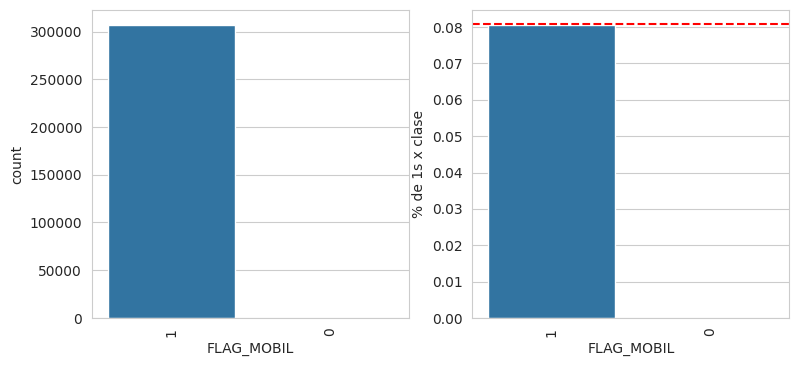

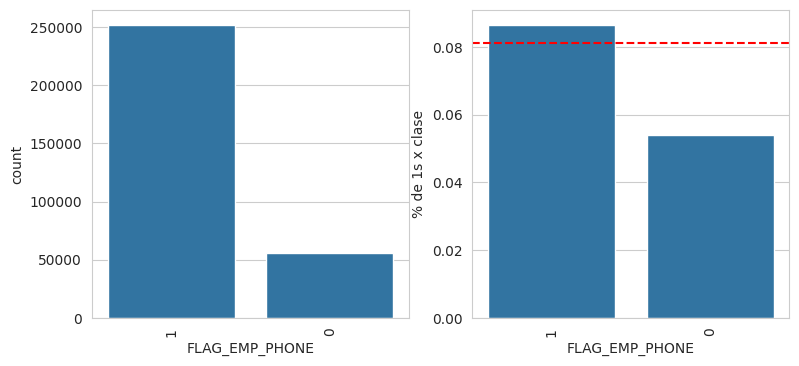

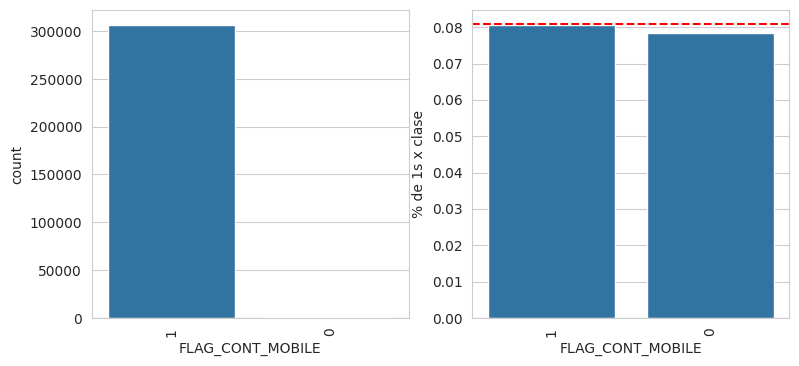

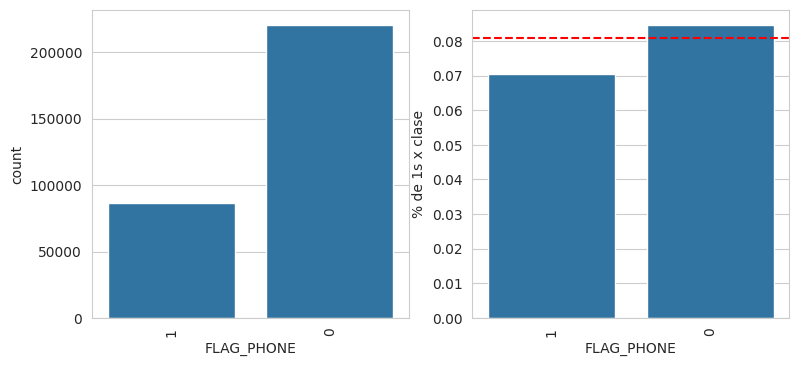

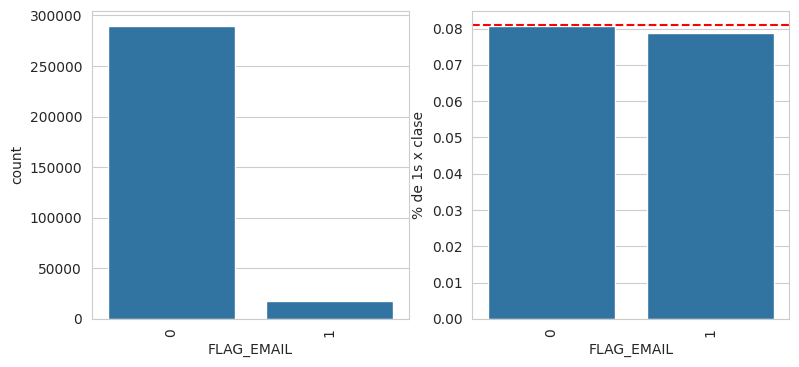

In [32]:
graficar_EDA(data,'TARGET',inf_comunicacion)

### Informacion direccion
- REGION_RATING_CLIENT : Calificacion de la region en la que vive el cliente
- REGION_RATING_CLIENT_W_CITY : Calificacion de la region en la que vive el cliente teniendo en cuenta la ciudad
- REG_REGION_NOT_LIVE_REGION : La dirección permanente del cliente coincide con la dirección de contacto a nivel de región?
- REG_REGION_NOT_WORK_REGION : Similar a la anterior pero indica la region de trabajo
- LIVE_REGION_NOT_WORK_REGION :  Evalúa la coincidencia entre la dirección permanente y la dirección del trabajo a nivel de región.

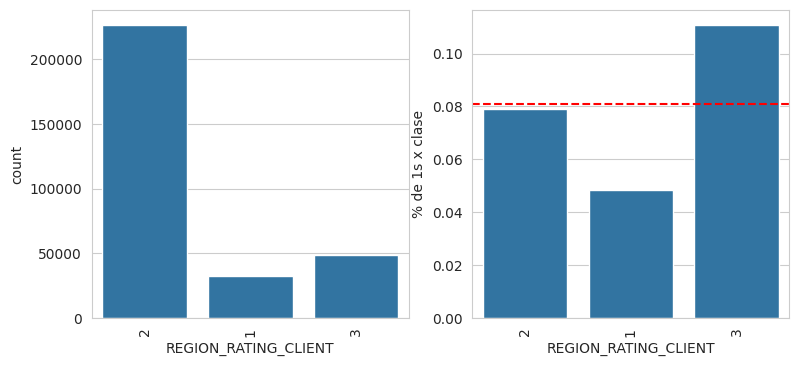

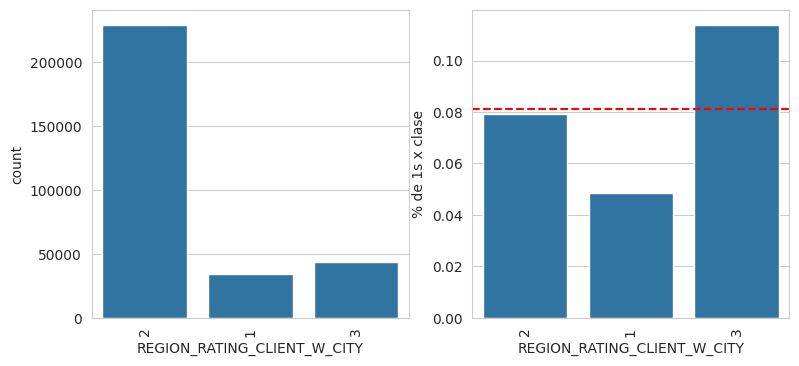

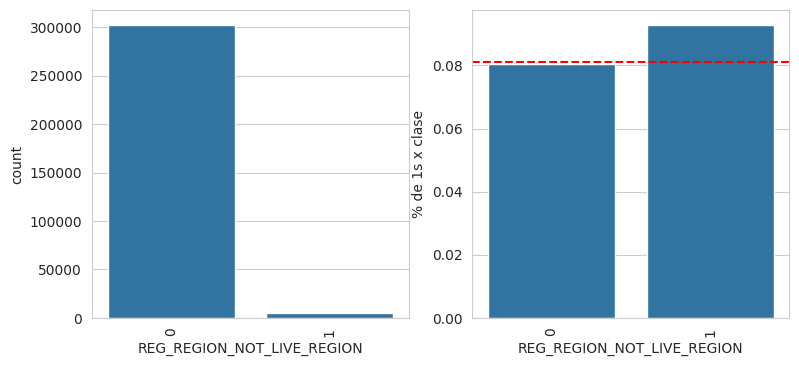

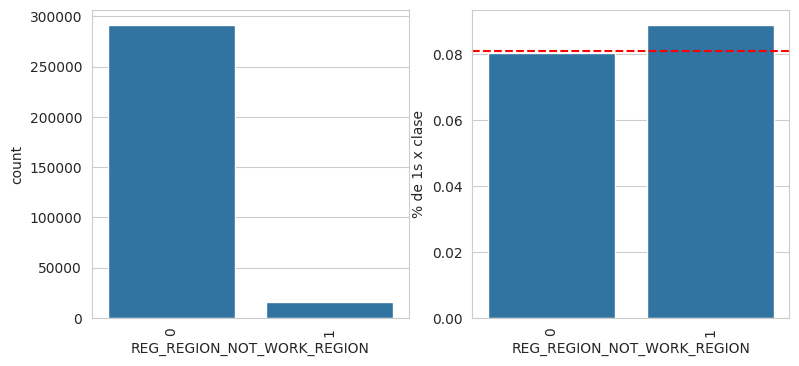

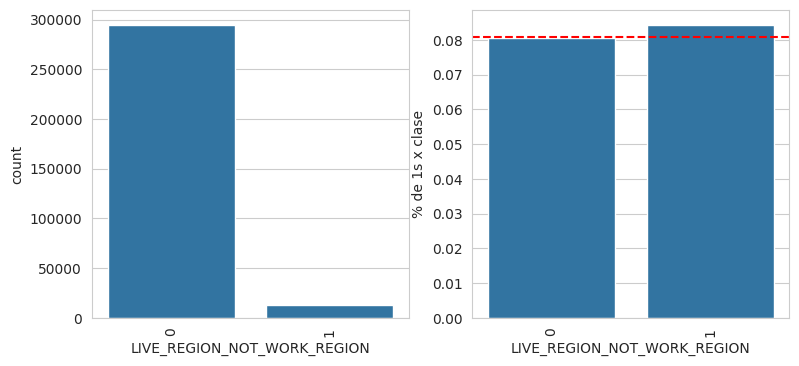

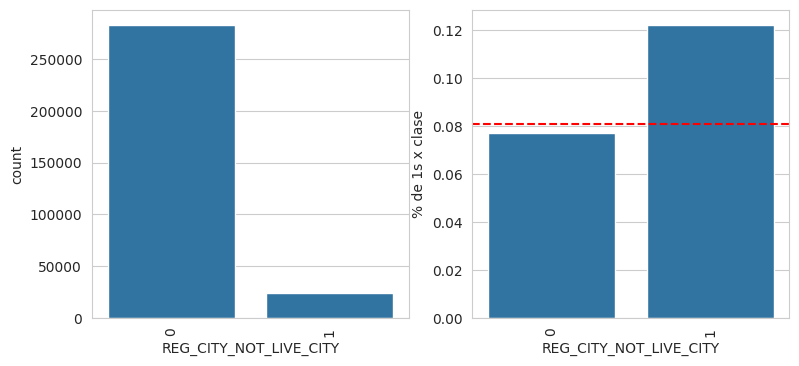

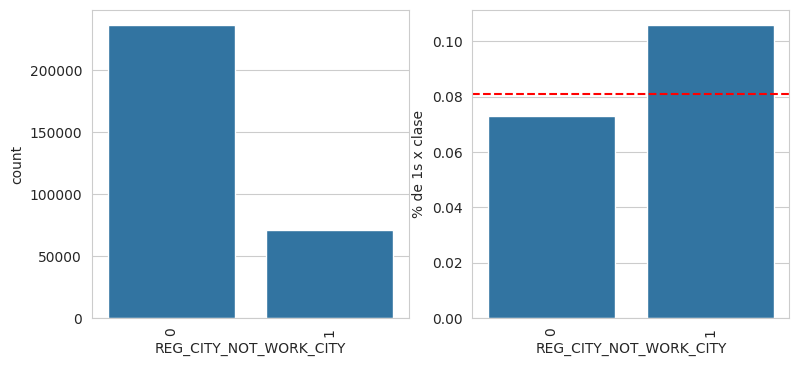

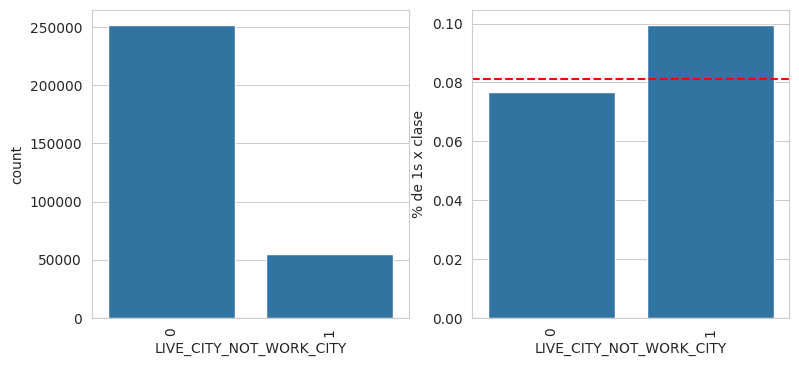

In [33]:
graficar_EDA(data,'TARGET',inf_direccion)

### Informacion scores
- EXTERNAL_SOURCE_1 : Score del cliente (fuente1)
- EXTERNAL_SOURCE_2 : Score del cliente (fuente2)
- EXTERNAL_SOURCE_3 : Score del cliente (fuente3)

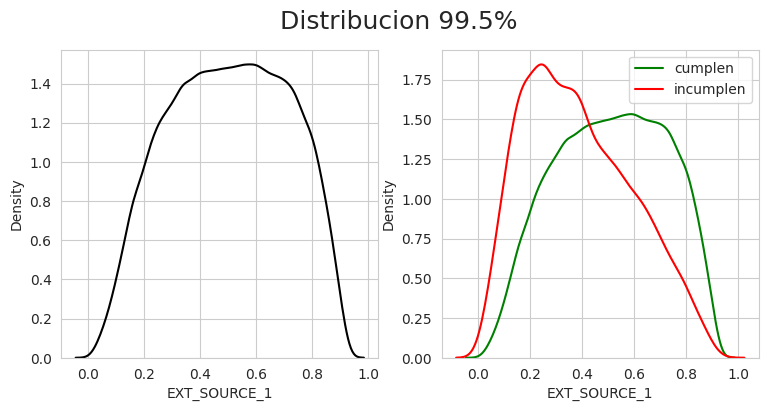

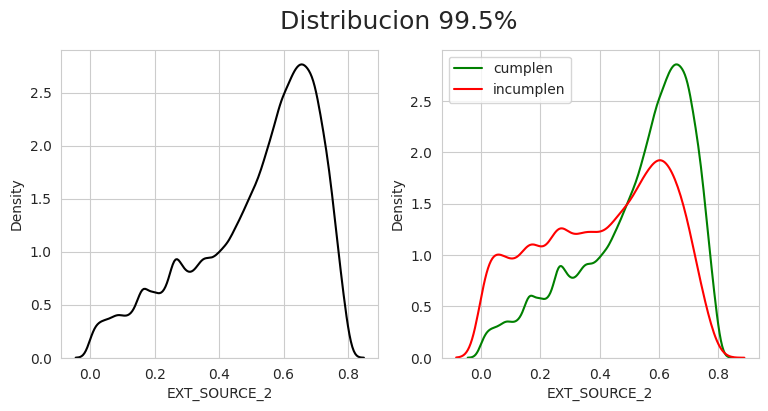

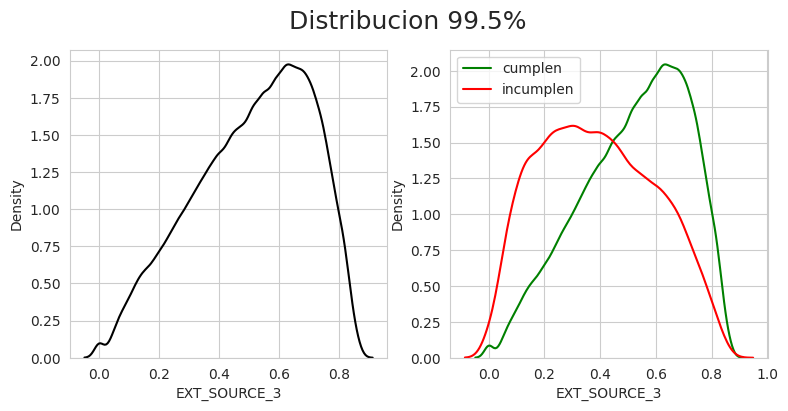

In [34]:
graficar_EDA(data,'TARGET',inf_scores)

### Informacion de llamadas al bureau
1. AMT_REQ_CREDIT_BUREAU_HOUR : Consultas al bureau de credito en la ultima hora sobre ese cliente
2. AMT_REQ_CREDIT_BUREAU_DAY : Consultas al bureau de credito en el ultimo dia sobre ese cliente
3. AMT_REQ_CREDIT_BUREAU_WEEK : Consultas al bureau de credito en la ultima semana sobre ese cliente
4. AMT_REQ_CREDIT_BUREAU_MON : Consultas al bureau de credito en el ultmo mes sobre ese cliente

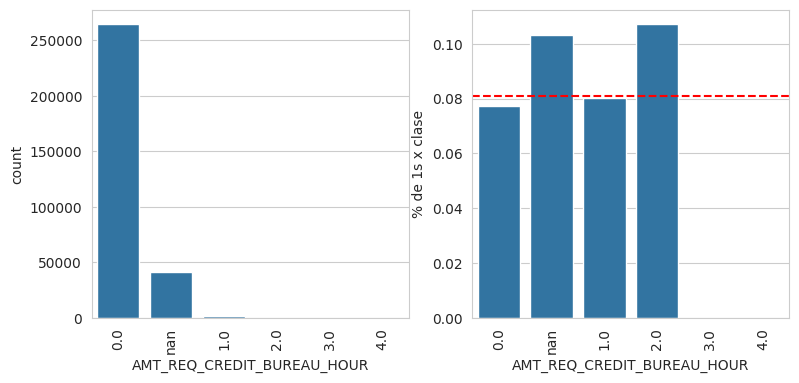

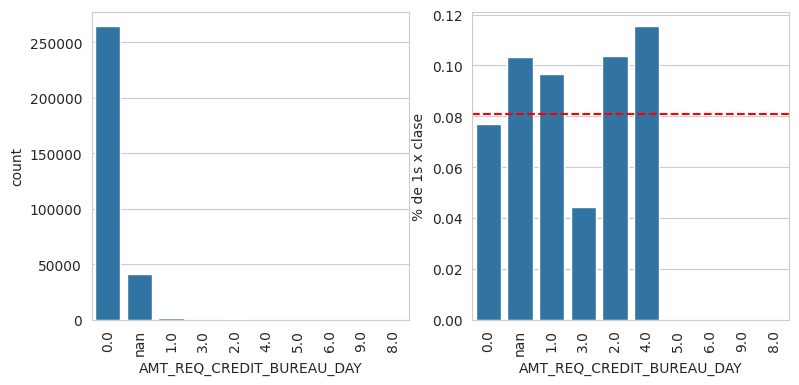

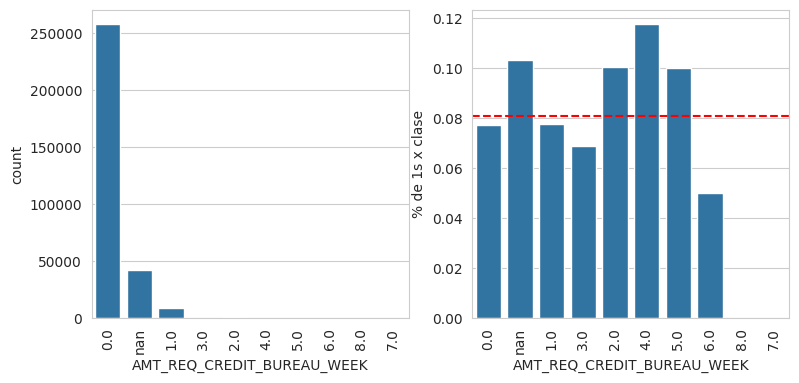

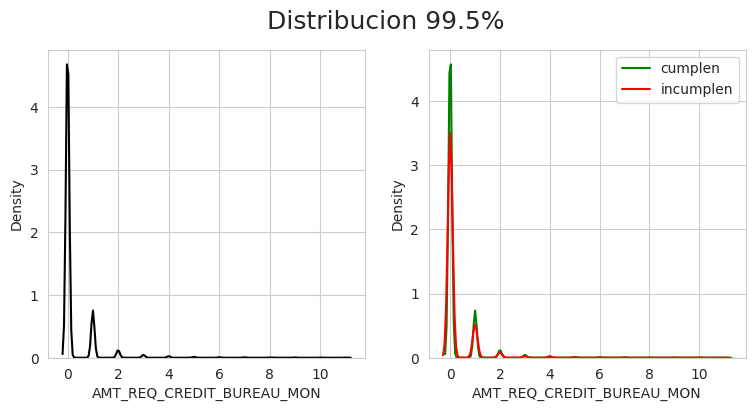

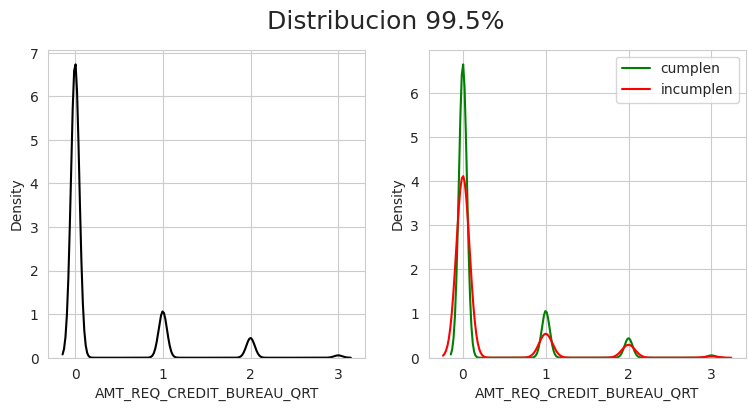

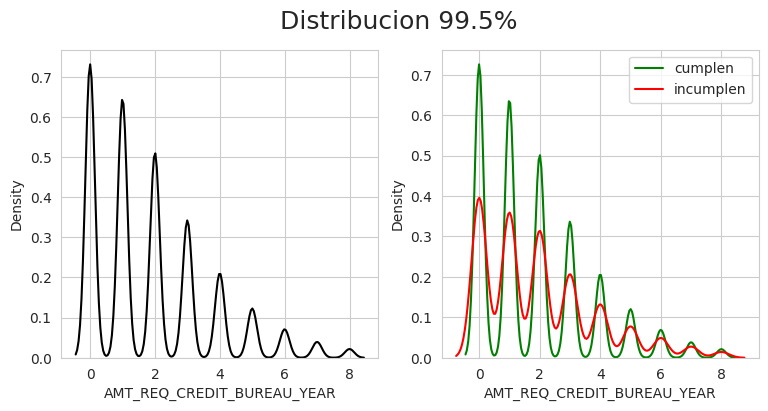

In [35]:
graficar_EDA(data,'TARGET',inf_bureauCalls)

In [53]:
def excluir_outliers(data,var,k):
    q1 = data[var].quantile(0.25)
    q3 = data[var].quantile(0.75)
    iqr = q3-q1
    cota_inferior = q1 - k*iqr
    cota_superior = q3 + k*iqr
    data_ = data.query(f'{var} > {cota_inferior} and {var} < {cota_superior}')
    return data_[var]

def sns_scatterplot(data,x,y,hue,k1,k2):
    data2 = data.copy()
    data2[x] = excluir_outliers(data2,x,k1)
    data2[y] = excluir_outliers(data2,y,k2)
    plt.figure(figsize=(6,6))
    sns.scatterplot(data2,x=x,y=y,hue=hue)
    plt.show()